In [1]:
import networkx as nx
import string
import matplotlib.pyplot as plt
import osmnx as ox
import pandas as pd

def generate_streetnetwork():

    """
    Load a network from OSMNX which will be used for the simulation runs. The generated network is from Rotterdam.
    Returns
    -------
    G: network MultiGraph
        Network Graph with different attributes:
            Nodes and Edges with LineString with coordinates,
            Edges have properties Speed, Travel time, Length.

    """
    lonlat=     'Netherlands'                                 #coordinates of the city centre of Rotterdam
    roadtype=   "drive"                                     #select only roads which are driveable by the car.

    cf = '["highway"~"motorway|motorway_link"]'
    # cf = '["highway"~"primary"]'  # orange roads OSM viewer
    # cf = '["highway"~"motorway|motorway_link|primary|secondary"]'
    # cf = '["highway"~"motorway|motorway_link|trunk|trunk_link|primary|secondary"]'

    ox.settings.log_console=True
    ox.settings.use_cache=True
    # ox.config(use_cache=True, log_console=True)

    # download street network data from OSM and construct a MultiDiGraph model
    # G = ox.graph_from_address('Emmerich, Germany', dist=10000, simplify=True, custom_filter=cf)
    G = ox.graph_from_address('Ede, Netherlands', dist=180000, simplify=True, custom_filter=cf)

    # G = ox.graph_from_place('Almelo, Netherlands', network_type='drive', simplify=True, custom_filter=cf)

    # default speeds
    hwy_speeds = {'motorway': 100,
                    'trunk': 100,
                    'residential': 50,
                    'tertiary': 50} #etc

    G = ox.add_edge_speeds(G, hwy_speeds=hwy_speeds)
    G = ox.add_edge_travel_times(G, precision=1)

    return G

In [2]:
def save_graph(G):
    filepath=f"graphs/FLEE/Graph_FLEE.graph.graphml"
    # ox.save_graph_geopackage(G, filepath=filepath)
    ox.save_graphml(G,filepath)

In [3]:
def draw_edges(graph):
    edges_fugitive = []

    # for i_r, route_time in enumerate(fugitive_routes):
    #     route = list(route_time.values())
    #     for i, node in enumerate(route):
    #         if i ==0:
    #             continue
    #         else:
    #             edges_fugitive1 = [(route[i], route[i-1])]
    #             edges_fugitive2 = [(route[i-1], route[i])]
    #             edges_fugitive.extend(tuple(edges_fugitive1))
    #             edges_fugitive.extend(tuple(edges_fugitive2))

    edge_colormap = ['lightgray'] * len(graph.edges())
    edge_weightmap = [1] * len(graph.edges())
    for index, edge in enumerate(graph.edges()):
        if edge in edges_fugitive:
            edge_colormap[index] = 'tab:orange'
            edge_weightmap[index] = 2

    return edge_colormap, edge_weightmap

In [4]:
# city = ("")
# distance = 2400
#
G=generate_streetnetwork()
# save_graph(G, city, distance)
#
# print(len(G.nodes()))

# show_graph(city, distance)

In [37]:
save_graph(G)

In [5]:
def show_graph():
    # filepath=f"graphs/FLEE/Graph_FLEE.graph.graphml"
    # G = ox.load_graphml(filepath=filepath)

    config = 3

    edge_colormap, edge_weightmap = draw_edges(G)
    suspect_start = ox.nearest_nodes(G, 5.1214, 52.0907)  # Utrecht

    node_size = []
    node_color = []
    for node in G.nodes:
        if node == suspect_start:
            node_size.append(40)
            node_color.append('red')
        else:
            node_size.append(0)
            node_color.append('lightgray')

    fig, ax = ox.plot_graph(
                G, bgcolor="white", node_color=node_color, node_size=node_size, edge_linewidth=edge_weightmap, edge_color=edge_colormap,
                save=True, filepath=f'graphs/FLEE/Graph_FLEE.png'
                )
    # ax.savefig('graphs/FLEE/Graph_FLEE.png')

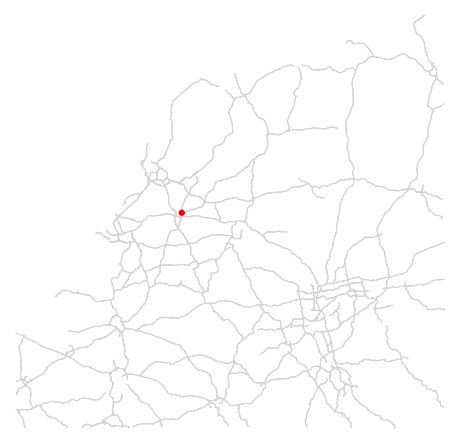

In [6]:
show_graph()

## Find border nodes

In [10]:
import geopandas as gpd
import shapely

filepath=f"graphs/FLEE/Graph_FLEE.graph.graphml"
G = ox.load_graphml(filepath=filepath)

In [11]:
nodes_gdf, streets = ox.graph_to_gdfs(G, nodes=True, edges=True,
                            node_geometry=False, fill_edge_geometry=True)
streets = streets.to_crs(4326)
streets

osmid  \
u           v           key                                                      
618911      6532006563  0    [155730916, 391386445, 287081719, 336366552, 6...   
            761583976   0    [681170628, 60102757, 1033355386, 60102760, 29...   
618940      618941      0    [94826624, 933993955, 933993956, 93238798, 373...   
618941      485959947   0                                [373851947, 26836526]   
            1088207401  0                      [373851929, 24578260, 24578257]   
...                                                                        ...   
10832852182 99241942    0                                             24321911   
            330660452   0                                            151946967   
10832852187 10832852182 0                                             24321893   
10867729294 10867729295 0                                           1168572859   
10867729295 249156904   0                                            151947020   

                             oneway   lanes   ref        highway   maxspeed  \
u           v           key                                                   
618911      6532006563  0      True  [3, 2]  A 23       motorway         90   
            761583976   0      True       2  A 27       motorway  [90, 110]   
618940      618941      0      True  [3, 2]   E42       motorway        120   
618941      485959947   0      True  [2, 1]   NaN  motorway_link        NaN   
            1088207401  0      True       2   E42       motorway        120   
...                             ...     ...   ...            ...        ...   
10832852182 99241942    0      True       1  A 45  motorway_link       none   
            330660452   0      True       1   NaN  motorway_link       none   
10832852187 10832852182 0      True       2  A 45  motorway_link       none   
10867729294 10867729295 0      True     NaN   NaN  motorway_link        NaN   
10867729295 249156904   0      True       2  A 45       motorway         80   

                            reversed    length  \
u           v           key                      
618911      6532006563  0      False  1550.394   
            761583976   0      False  7898.626   
618940      618941      0      False  1557.967   
618941      485959947   0      False   344.239   
            1088207401  0      False   860.905   
...                              ...       ...   
10832852182 99241942    0      False   253.566   
            330660452   0      False   270.065   
10832852187 10832852182 0      False    51.827   
10867729294 10867729295 0      False   149.352   
10867729295 249156904   0      False    66.474   

                                                                      geometry  \
u           v           key                                                      
618911      6532006563  0    LINESTRING (3.13524 50.60021, 3.13644 50.59978...   
            761583976   0    LINESTRING (3.13524 50.60021, 3.13540 50.60017...   
618940      618941      0    LINESTRING (3.42313 50.62068, 3.42337 50.62026...   
618941      485959947   0    LINESTRING (3.43036 50.60744, 3.43035 50.60726...   
            1088207401  0    LINESTRING (3.43036 50.60744, 3.43069 50.60684...   
...                                                                        ...   
10832852182 99241942    0    LINESTRING (8.28300 50.67667, 8.28303 50.67629...   
            330660452   0    LINESTRING (8.28300 50.67667, 8.28298 50.67658...   
10832852187 10832852182 0      LINESTRING (8.28302 50.67713, 8.28300 50.67667)   
10867729294 10867729295 0    LINESTRING (8.34996 50.62513, 8.34996 50.62505...   
10867729295 249156904   0      LINESTRING (8.34804 50.62504, 8.34710 50.62511)   

                             speed_kph  travel_time bridge name tunnel width  \
u           v           key                                                    
618911      6532006563  0         90.0         62.0    NaN  NaN    NaN   NaN   
            76158397

In [12]:
# import geopackage file in geopandas
nld = gpd.read_file("graphs/FLEE/geodata/BestuurlijkeGebieden_2023.gpkg", layer=1)
# nld = gpd.read_file("graphs/FLEE/Netherlands_shapefile/nl_1km.shp")
nld = nld.to_crs(4326)
nld

,identificatie,naam,code,geometry
0,LND6030,Nederland,6030,"MULTIPOLYGON (((4.87125 51.41135, 4.87185 51.4..."


C:\Users\isvandroffelaa\AppData\Local\Temp\ipykernel_9008\3698462814.py:1: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  multiLines = shapely.geometry.MultiLineString([x.exterior for x in nld.geometry[0]])


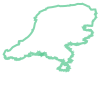

In [13]:
multiLines = shapely.geometry.MultiLineString([x.exterior for x in nld.geometry[0]])
multiLines

In [14]:
lines = streets.geometry.unary_union
intersection = lines.intersection(nld.geometry[0])
# [p for p in intersection.geoms]
type(intersection)

shapely.geometry.multilinestring.MultiLineString

In [15]:
intersectionn = gpd.sjoin(streets, nld)

<AxesSubplot:>

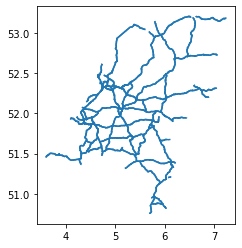

In [16]:
intersectionn.plot()

In [17]:
intersectionn

osmid  \
u           v           key                                                      
42683358    10143747481 0                                 [634366932, 7622174]   
            42696357    0                      [382751729, 382751740, 7622183]   
42683978    3769666495  0                    [382751738, 141114348, 382751732]   
42695391    42683978    0               [7622169, 7622170, 476363989, 7622177]   
                        1                        [7622184, 382751737, 7622179]   
...                                                                        ...   
5568345355  5074865063  0                               [638232378, 580977622]   
5633561021  166976112   0    [1165698629, 16310746, 1165698621, 53835742, 5...   
6124799426  46055827    0                                 [6660204, 807780439]   
9193958342  1554083264  0                                            377100597   
10844402810 45852761    0    [326375393, 326375394, 326375395, 6672586, 667...   

                             oneway      lanes  ref        highway  \
u           v           key                                          
42683358    10143747481 0      True          1  A58  motorway_link   
            42696357    0      True          2  A58       motorway   
42683978    3769666495  0      True     [3, 4]  A58       motorway   
42695391    42683978    0      True          1  A58  motorway_link   
                        1      True          2  A58       motorway   
...                             ...        ...  ...            ...   
5568345355  5074865063  0      True     [3, 2]  A35  motorway_link   
5633561021  166976112   0      True          1  A35  motorway_link   
6124799426  46055827    0      True     [2, 1]   A1  motorway_link   
9193958342  1554083264  0      True          1  N35  motorway_link   
10844402810 45852761    0      True  [3, 4, 2]  A35       motorway   

                                   maxspeed reversed    length  \
u           v           key                                      
42683358    10143747481 0         [80, 100]    False   349.168   
            42696357    0               100    False   828.906   
42683978    3769666495  0         [70, 100]    False   512.372   
42695391    42683978    0    [60, 130, 100]    False   780.221   
                        1               100    False   787.817   
...                                     ...      ...       ...   
5568345355  5074865063  0                80    False   986.059   
5633561021  166976112   0         [50, 130]    False   465.921   
6124799426  46055827    0               100    False   636.238   
9193958342  1554083264  0               100    False   560.023   
10844402810 45852761    0               100    False  2234.981   

                                                                      geometry  \
u           v           key                                                      
42683358    10143747481 0    LINESTRING (3.60419 51.45901, 3.60482 51.45913...   
            42696357    0    LINESTRING (3.60419 51.45901, 3.60704 51.46001...   
42683978    3769666495  0    LINESTRING (3.60375 51.45899, 3.60252 51.45855...   
42695391    42683978    0    LINESTRING (3.61243 51.46340, 3.61189 51.46303...   
                        1    LINESTRING (3.61243 51.46340, 3.61230 51.46326...   
...                                                                        ...   
5568345355  5074865063  0    LINESTRING (6.81723 52.20845, 6.81770 52.20831...   
5633561021  166976112   0    LINESTRING (6.59455 52.34154, 6.59455 52.34149...   
6124799426  46055827    0    LINESTRING (6.89036 52.29560, 6.89023 52.29563...   
9193958342  1554083264  0    LINESTRING (6.89004 52.20131, 6.88748 52.20140...   
10844402810 45852761    0    LINESTRING (6.75133 52.26166, 6.75139 52.26135...   

                             speed_kph  ...  name tunnel width access  \
u           v           key             ...                             
42683358    10143747481

In [18]:
unique_osmids_u = list(intersectionn.index.unique(level=0))
unique_osmids_v = list(intersectionn.index.unique(level=1))
unique_osmids = list(set(unique_osmids_u) | set(unique_osmids_v))
# nodes_gdf.iloc[unique_osmids]
nodes_gdf_intersection = nodes_gdf[nodes_gdf.index.isin(unique_osmids)]

In [19]:
len(unique_osmids)

6836

In [20]:
nodes_gdf_intersection

,y,x,highway,street_count,ref
osmid,,,,,
42683358,51.459015,3.604187,motorway_junction,3,40
42683978,51.458992,3.603745,NaN,3,NaN
42695391,51.463402,3.612432,motorway_junction,3,40
42696357,51.463815,3.613056,NaN,3,NaN
42728817,51.475306,3.630920,motorway_junction,3,39
...,...,...,...,...,...
6124799427,52.295531,6.890280,NaN,1,NaN
7391914308,52.280524,6.849549,NaN,1,NaN
9193958342,52.201307,6.890043,NaN,3,NaN


In [21]:
G_intersection = ox.graph_from_gdfs(nodes_gdf_intersection, intersectionn)

In [22]:
border_crossings = streets.geometry.unary_union.intersection(multiLines)  # streets.intersection(multiLines)
latlon_x = [round(p.x, 2) for p in border_crossings.geoms]
latlon_y = [round(p.y, 3) for p in border_crossings.geoms]
latlon_x, latlon_y

([7.23,
  7.23,
  6.07,
  6.16,
  4.74,
  4.3,
  4.3,
  6.03,
  4.3,
  6.02,
  4.3,
  4.3,
  5.75,
  5.7,
  6.22,
  6.22,
  4.74,
  7.22,
  5.21,
  5.21,
  5.75,
  6.16,
  5.7,
  6.17,
  6.17,
  6.03,
  6.22,
  6.03,
  6.17,
  6.17,
  6.07,
  6.02,
  6.03,
  7.22,
  7.04,
  7.04],
 [53.18,
  53.18,
  51.201,
  51.901,
  51.486,
  51.377,
  51.377,
  51.675,
  51.377,
  50.819,
  51.377,
  51.377,
  50.959,
  50.755,
  51.384,
  51.384,
  51.486,
  53.179,
  51.319,
  51.319,
  50.959,
  51.901,
  50.755,
  51.899,
  51.899,
  51.675,
  51.384,
  51.675,
  51.333,
  51.333,
  51.2,
  50.819,
  50.819,
  53.178,
  52.314,
  52.314])

In [23]:
for node, data in G.nodes(data=True):
    # print(data)
    if round(data['y'], 3) in latlon_y:
        if round(data['x'], 2) in latlon_x:
            print(data['y'], data['x'])
    # if round(data['x'], 2) in latlon_x:
    #     print(round(data['x'], 2))

51.6750251 6.0269683
51.6750345 6.0298784
51.8993284 6.1645577
51.6751902 6.0342848
51.9012034 6.1628402
51.8989201 6.1657414
51.3844528 6.2160931
51.2004814 6.0709838
51.2005922 6.0709708
50.8193853 6.0254126
50.8188057 6.2180981
50.818588 6.2170572
50.8188024 6.217665
53.1789664 7.2211575
53.1787702 7.2209648
53.1790566 7.2195357
53.1776437 7.2160832
53.177687 7.2155977
53.1791353 7.2213599


    ## Construct locations.csv

In [24]:
intersection_lines = lines.intersection(multiLines)
latlon_x = [round(p.x, 2) for p in intersection_lines.geoms]
latlon_y = [round(p.y, 2) for p in intersection_lines.geoms]
# latlon_x, latlon_y

In [25]:
def show_graph_camp(G, latlon_y, latlon_x):
    edge_colormap, edge_weightmap = draw_edges(G)

    node_size = []
    node_color = []
    for node, data in G.nodes(data=True):
        if (round(data['y'], 2) in latlon_y) and (round(data['x'], 2) in latlon_x):
            print(data['y'], data['x'])
            node_size.append(40)
            node_color.append('red')
        else:
            node_size.append(0)
            node_color.append('lightgray')

    fig, ax = ox.plot_graph(
                G, bgcolor="white", node_color=node_color, node_size=node_size, edge_linewidth=edge_weightmap, edge_color=edge_colormap,
                save=True, filepath=f'graphs/FLEE/Graph_FLEE.png'
                )

51.3789567 4.3029141
51.3815831 4.3017373
51.3781673 4.304417
51.3808049 4.3025407
51.4889228 4.7368481
51.4920493 4.7378658
51.3207702 5.2148503
51.6750251 6.0269683
51.6750345 6.0298784
51.9044939 6.1594169
51.9045362 6.1591337
51.9012034 6.1628402
51.8974821 6.1668823
51.8989201 6.1657414
51.9024899 6.1617303
51.6751902 6.0342848
51.8993284 6.1645577
51.8955755 6.1686237
51.9019463 6.1635735
51.3828712 6.03202
51.382431 6.221466
51.3834072 6.218683
51.3844528 6.2160931
51.382902 6.0326499
50.8246761 6.0184986
51.202717 6.0280111
51.2024703 6.0279414
51.2004814 6.0709838
51.2005922 6.0709708
50.8193853 6.0254126
50.8218633 6.0245144
50.8201841 6.0241099
50.820429 6.0228079
50.8202771 6.0227262
50.8160755 6.0272619
50.82099 6.02279
50.8216392 6.0219269
50.8219746 6.021239
50.8222699 6.0207387
50.8225463 6.0210072
50.824743 6.0187792
50.8229847 6.0209277
50.8243229 6.0198126
50.8242011 6.0186663
50.8169463 6.0267015
53.177687 7.2155977
53.1789664 7.2211575
53.1787702 7.2209648
53.17913

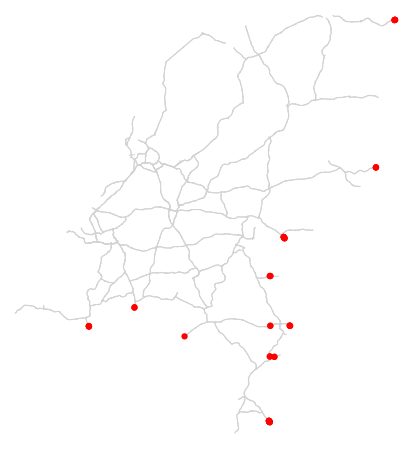

In [26]:
show_graph_camp(G_intersection, latlon_y, latlon_x)

## routes.csv

In [30]:
routes_dict = defaultdict(list)

for u, v, data in G.edges(data=True):
    #"name1"	name2	distance	forced_redirection
    routes_dict['name1'].append(u)
    routes_dict['name2'].append(v)
    routes_dict['distance'].append(data['travel_time'])
    routes_dict['forced_redirection'].append(0)

routes_df = pd.DataFrame.from_dict(routes_dict, orient='columns')

In [31]:
routes_df.to_csv('graphs/FLEE/routes.csv', index=False)
routes_df

,name1,name2,distance,forced_redirection
0,618911,6532006563,62.0,0
1,618911,761583976,284.4,0
2,618940,618941,46.7,0
3,618941,485959947,13.8,0
4,618941,1088207401,25.8,0
...,...,...,...,...
23501,10832852182,99241942,10.2,0
23502,10832852182,330660452,10.8,0
23503,10832852187,10832852182,2.1,0
23504,10867729294,10867729295,6.0,0


## conflicts.csv

In [32]:
ox.nearest_nodes(G, 52.0907, 5.1214)  # Utrecht

25263930

In [42]:
suspect_start = ox.nearest_nodes(G, 5.1214, 52.0907)  # Utrecht}
# columns=['day', 'name', 'node', 'D'])
conflicts_dict = {'Day': [0], 'name': [0], suspect_start: [1]}

In [43]:
conflicts_df = pd.DataFrame.from_dict(conflicts_dict, orient='columns')

In [44]:
anpr = pd.read_excel('anpr_camera_locaties.xlsx')
anpr

,locatienaam,eenheid,plaats,Gemeente,latitude,longitude,reden 1,reden 2,reden 3,reden 4
0,01 Emmaviad. ri Julianapl,Noord-Nederland,Groningen,Groningen,53.206667,6.562222,x,x,x,x
1,01 Emmaviaduct ri Centrum,Noord-Nederland,Groningen,Groningen,53.206667,6.562500,x,x,x,x
2,01 LWRDN Adlansdk ri Greunsbrg,Noord-Nederland,Leeuwarden,Leeuwarden,53.190627,5.822761,x,x,x,x
3,01 LWRDN Greunsbrug,Noord-Nederland,Leeuwarden,Leeuwarden,53.192953,5.835629,x,x,x,x
4,01 LWRDN Holstmrwg richting PI,Noord-Nederland,Leeuwarden,Leeuwarden,53.191878,5.823654,x,x,x,x
...,...,...,...,...,...,...,...,...,...,...
776,S109 Beneluxbaan A-veen IN,Amsterdam,Amstelveen,Amstelveen,52.321388,4.868951,NaN,x,x,NaN
777,S112 Gooiseweg x Toerit A10,Amsterdam,Duivendrecht,Ouder-Amstel,52.336389,4.943056,NaN,x,x,NaN
778,SPL Ceintuurbaan inkeer,Noord-Holland,Schiphol,Haarlemmermeer,52.306944,4.751944,x,x,NaN,NaN
779,SPL Citizen M J. Plezierweg,Noord-Holland,Schiphol,Haarlemmermeer,52.309167,4.755000,x,x,NaN,NaN


In [49]:
anpr_nodes = []
for lat, lon in zip(anpr['latitude'], anpr['longitude']):
    anpr_nodes.append(ox.nearest_nodes(G, lon, lat))

anpr_nodes = list(set(anpr_nodes))

51.3789567 4.3029141
51.3815831 4.3017373
51.3781673 4.304417
51.3808049 4.3025407
51.4889228 4.7368481
51.4920493 4.7378658
51.3207702 5.2148503
51.6750251 6.0269683
51.6750345 6.0298784
51.9044939 6.1594169
51.9045362 6.1591337
51.9012034 6.1628402
51.8974821 6.1668823
51.8989201 6.1657414
51.9024899 6.1617303
51.6751902 6.0342848
51.8993284 6.1645577
51.8955755 6.1686237
51.9019463 6.1635735
51.3828712 6.03202
51.382431 6.221466
51.3834072 6.218683
51.3844528 6.2160931
51.382902 6.0326499
50.8246761 6.0184986
51.202717 6.0280111
51.2024703 6.0279414
51.2004814 6.0709838
51.2005922 6.0709708
50.8193853 6.0254126
50.8218633 6.0245144
50.8201841 6.0241099
50.820429 6.0228079
50.8202771 6.0227262
50.8160755 6.0272619
50.82099 6.02279
50.8216392 6.0219269
50.8219746 6.021239
50.8222699 6.0207387
50.8225463 6.0210072
50.824743 6.0187792
50.8229847 6.0209277
50.8243229 6.0198126
50.8242011 6.0186663
50.8169463 6.0267015
53.177687 7.2155977
53.1789664 7.2211575
53.1787702 7.2209648
53.17913

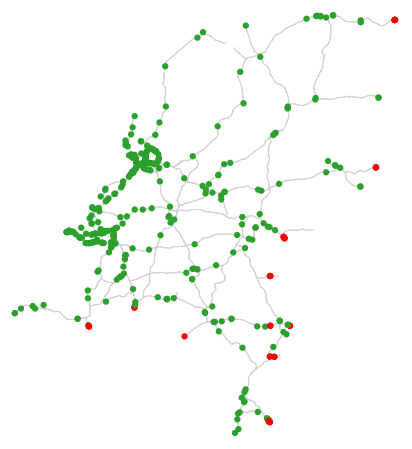

In [52]:
def show_graph_anpr(G, latlon_y, latlon_x):
    edge_colormap, edge_weightmap = draw_edges(G)

    node_size = []
    node_color = []
    for node, data in G.nodes(data=True):
        if (round(data['y'], 2) in latlon_y) and (round(data['x'], 2) in latlon_x):
            node_size.append(40)
            node_color.append('red')
        elif node in anpr_nodes:
            node_size.append(40)
            node_color.append('tab:green')
        else:
            node_size.append(0)
            node_color.append('lightgray')

    fig, ax = ox.plot_graph(
                G, bgcolor="white", node_color=node_color, node_size=node_size, edge_linewidth=edge_weightmap, edge_color=edge_colormap,
                save=True, filepath=f'graphs/FLEE/Graph_FLEE_anpr.png'
                )

show_graph_anpr(G_intersection, latlon_y, latlon_x)

In [54]:
for anpr_node in anpr_nodes:
    conflicts_df[anpr_node] = 0.1

C:\Users\isvandroffelaa\AppData\Local\Temp\ipykernel_9008\4087037734.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  conflicts_df[anpr_node] = 0.1
C:\Users\isvandroffelaa\AppData\Local\Temp\ipykernel_9008\4087037734.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  conflicts_df[anpr_node] = 0.1
C:\Users\isvandroffelaa\AppData\Local\Temp\ipykernel_9008\4087037734.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider j

In [55]:
conflicts_df

,Day,name,891052014,48154269,2451963173,5752480803,45574633,45553582,45548152,8210300057,...,47118220,45916046,47556509,8300535767,42999772,8241229789,43929576,581955572,44599284,47962110
0,0,0,1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,...,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1


In [56]:
conflicts_df.to_csv('graphs/FLEE/conflicts.csv', index=False)
conflicts_df

,Day,name,891052014,48154269,2451963173,5752480803,45574633,45553582,45548152,8210300057,...,47118220,45916046,47556509,8300535767,42999772,8241229789,43929576,581955572,44599284,47962110
0,0,0,1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,...,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1


## locations.csv

In [57]:
from collections import defaultdict

locations_dict = defaultdict(list)

suspect_start = ox.nearest_nodes(G, 5.1214, 52.0907)

for node, data in G.nodes(data=True):
    locations_dict['name'].append(node)
    locations_dict['lat'].append(data['y'])
    locations_dict['lon'].append(data['x'])

    # locations_dict['location_type'].append('town')
    locations_dict['region'].append('xyz')
    locations_dict['country'].append('xyz')
    locations_dict['conflict_date'].append(0)
    locations_dict['population'].append(0)

    if round(data['y'], 2) in latlon_y and round(data['x'], 2) in latlon_x:
        locations_dict['location_type'].append('camp')  # border crossing = 'camp'
    elif node == suspect_start:
        locations_dict['location_type'].append('conflict')  # start suspects
    elif node in anpr_nodes:
        locations_dict['location_type'].append('conflict')  # anpr cameras
    else:
        locations_dict['location_type'].append('town')
    # if round(data['x'], 2) in latlon_x:
    #     print(round(data['x'], 2))

locations_df = pd.DataFrame.from_dict(locations_dict, orient='columns')

In [58]:
locations_df.to_csv('graphs/FLEE/locations.csv', index=False)
locations_df

,name,lat,lon,region,country,conflict_date,population,location_type
0,618911,50.600211,3.135241,xyz,xyz,0,0,town
1,618940,50.620683,3.423134,xyz,xyz,0,0,town
2,618941,50.607444,3.430364,xyz,xyz,0,0,town
3,621890,50.634832,3.398914,xyz,xyz,0,0,town
4,621893,50.626114,3.419775,xyz,xyz,0,0,town
...,...,...,...,...,...,...,...,...
20699,10243233107,50.724260,8.281058,xyz,xyz,0,0,town
20700,10832852182,50.676667,8.282998,xyz,xyz,0,0,town
20701,10832852187,50.677133,8.283019,xyz,xyz,0,0,town
20702,10867729294,50.625129,8.349959,xyz,xyz,0,0,town
